In [1]:
import os
import torch
print(torch.__version__)

2.4.0+cu124


In [2]:
enableWandb = True

In [3]:
if enableWandb:
    import wandb
    wandb.login()    

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: deepakpokkalla. Use `wandb login --relogin` to force relogin


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

Processing...
Done!


In [6]:
print(dataset)
print(len(dataset))
print(dataset.num_classes)
print(dataset.num_node_features)
print(dataset.num_edge_features)

MUTAG(188)
188
2
7
4


In [7]:
print(dataset[0])
print(dataset[0].x)
print(dataset[0].edge_attr)

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
     

<Axes: ylabel='Count'>

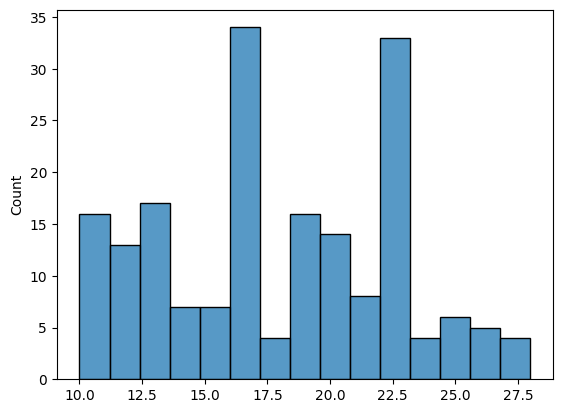

In [8]:
import seaborn as sns

sns.histplot([d.num_nodes for d in dataset], bins=15)

<Axes: ylabel='Count'>

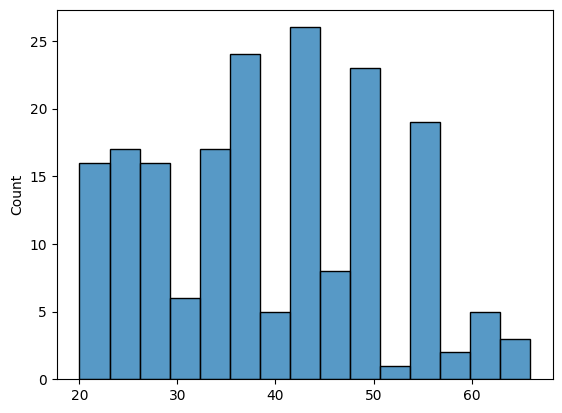

In [9]:
sns.histplot([d.num_edges for d in dataset], bins=15)

<Axes: ylabel='Count'>

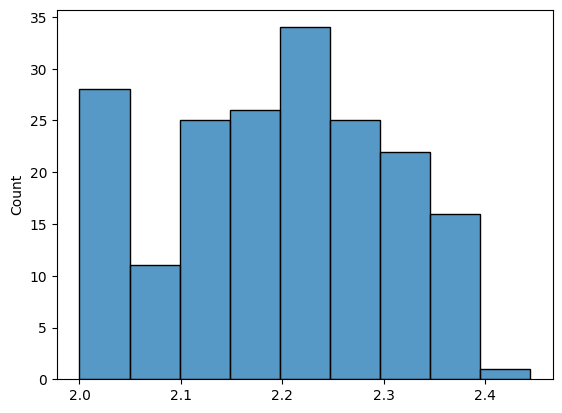

In [10]:
sns.histplot([d.num_edges/d.num_nodes for d in dataset])

Graph classification: example of induction. 2 classes => binary classification. 7 features per node (oneHot), 4 features per edge (oneHot). Each graph has more than 2:1 edges:nodes.

In [11]:
if enableWandb:
    wandbProject:str = 'edaGraphClassification'
    wandbRunName:str = 'analyzeData'
    wandb.init(project=wandbProject, name=wandbRunName)

In [12]:
import numpy as np

dataDetails = {
    'nNodeFeatures': dataset.num_node_features,
    'nEdgeFeatures': dataset.num_edge_features,
    'nGraphs': len(dataset),
    'nClasses': dataset.num_classes,
    'nNodes': np.array([d.num_nodes for d in dataset], dtype=np.int8),
    'nEdges': np.array([d.num_edges for d in dataset], dtype=np.int8)
}

import json

if enableWandb:
    wandb.log(dataDetails)


In [13]:
# print(json.dumps({k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in dataDetails.items()}, sort_keys=True, indent=4))

In [14]:
import wget
wget.download("https://gist.githubusercontent.com/mogproject/50668d3ca60188c50e6ef3f5f3ace101/raw/e11d5ac2b83fb03c0e5a9448ee3670b9dfcd5bf9/visualize.py")

'visualize (1).py'

In [15]:
# %run visualize.py
from visualize import GraphVisualization

In [16]:
import networkx as nx
from torch_geometric.utils import to_networkx
from matplotlib import pyplot as plt

def drawGraph(data):
    g = to_networkx(data, to_undirected=True)
    pos = nx.kamada_kawai_layout(g)
    fig, ax = plt.subplots()
    nx.draw_networkx(g, pos=pos, with_labels=True, node_size=250, ax=ax)
    return fig


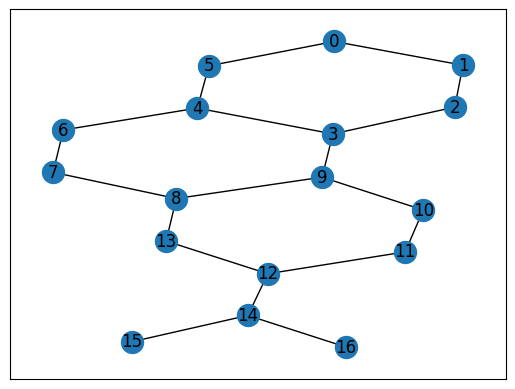

In [17]:
g = to_networkx(dataset[0], to_undirected=True)
pos = nx.kamada_kawai_layout(g)
fig, ax = plt.subplots()
nx.draw_networkx(g, pos=pos, with_labels=True, node_size=250, ax=ax)

In [18]:
import plotly
import plotly.tools as tools

if enableWandb:
    table = wandb.Table(columns=['graph', 'nNodes', 'nEdges', 'class'])
    for data in dataset:
        fig = drawGraph(data)
        nNodes = data.num_nodes
        nEdges = data.num_edges
        classLabel = data.y.item()
        table.add_data(wandb.Image(fig), nNodes, nEdges, classLabel)
        plt.close()
    wandb.log({'data': table})

In [19]:
if enableWandb:
    datasetArtifact = wandb.Artifact(name='MUTAG', type='dataset', metadata=dataDetails)
    datasetArtifact.add_dir('data/TUDataset')
    wandb.log_artifact(datasetArtifact)
    wandb.finish()

wandb: Adding directory to artifact (.\data\TUDataset)... Done. 0.0s


nClasses,▁
nEdgeFeatures,▁
nGraphs,▁
nNodeFeatures,▁
nClasses,2
nEdgeFeatures,4
nGraphs,188
nNodeFeatures,7


In [20]:
from torch.nn import Linear, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np

nConvs:np.int8 = 3
nHidden:np.int8 = 64
dropout:np.float32 = 0.5
nFeatures:np.int8 = dataset.num_features

class GCN(torch.nn.Module):
    def __init__(self, nConvs=nConvs, nHidden=nHidden, dropout=dropout):
        super(GCN, self).__init__()
        self.nConvs = nConvs
        self.nHidden = nHidden
        self.dropout = dropout
        temp = [GCNConv(nFeatures, nHidden)]
        for _ in range(1, nConvs):
            temp.append(GCNConv(nHidden, nHidden))
        self.convs = ModuleList(temp)
        self.linear = Linear(nHidden, 1)
        self.activation = F.relu

    def forward(self, x, edgeIndex, batchNode2GraphMap):
        h = self.activation(self.convs[0](x, edgeIndex))
        for i in range(1, self.nConvs):
            h = self.activation(self.convs[i](h, edgeIndex))
        h = global_mean_pool(h, batch=batchNode2GraphMap)
        h = F.dropout(h, p=self.dropout, training=self.training)
        return F.sigmoid(self.linear(h))

In [21]:
# A better way to distribute is based on classes, i.e., stratified sampling
# dataset = dataset.to(device)
trainData = dataset[:130]
valData = dataset[130:150]
testData = dataset[150:]

from torch_geometric.loader import DataLoader

# torch.manual_seed(0)
trainDataLoader = DataLoader(trainData, batch_size=64, shuffle=True)
valDataLoader = DataLoader(valData, batch_size=1)
testDataLoader = DataLoader(testData, batch_size=1)


In [22]:
import gc
gc.collect()

858249

In [24]:
enableWandb = True
if enableWandb:
    wandb.init(project='edaGraphClassification')
    art = wandb.use_artifact('deepakpokkalla/edaGraphClassification/MUTAG:v0')

In [25]:
torch.manual_seed = 0
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss(reduction="mean")

def train():
    model.train()
    totalLoss = 0.0
    for batch in trainDataLoader:
        optimizer.zero_grad()
        batch = batch.to(device)
        preds = model(batch.x, batch.edge_index, batch.batch).squeeze()
        loss = criterion(preds, batch.y.float())
        totalLoss += loss.item() * len(batch)
        loss.backward()
        optimizer.step()
    return totalLoss / len(trainData)

@torch.no_grad()
def valTest(mode = 'val', generatePlots=False):
    model.eval()
    loader = testDataLoader if mode == 'test' else valDataLoader
    if (mode == 'train'):
        loader = trainDataLoader
    accuracy = 0.0
    count = 0
    table = None
    if enableWandb and generatePlots:
        table = wandb.Table(columns=["truth", "prediction", "graph"])
    for batch in loader:
        batch = batch.to(device)
        preds = torch.round(model(batch.x, batch.edge_index, batch.batch))
        corrects = (preds == batch.y).sum().cpu().numpy()
        accuracy = (count * accuracy + corrects) / (count + len(batch))
        count += len(batch)
        if enableWandb and generatePlots:
            for i in range(len(batch)):
                fig = drawGraph(batch[i])
                truth = batch[i].y.item()
                pred = preds[i].item()
                table.add_data(truth, pred, wandb.Image(fig))
                plt.close()
    return accuracy, table



In [26]:
from copy import deepcopy
import tqdm

nEpochs:np.int16 = 200
patience:np.int8 = 20
modelBest = deepcopy(model)
patienceCount:np.int8 = 0
bestVal:np.float32 = 0.0
bestEpoch:np.int16 = 0
enableWandb = True
for epoch in tqdm.tqdm(range(nEpochs)):
    loss = train()
    val, _ = valTest(mode='val')
    print(f'Epoch: {epoch:3d}, Loss: {loss:.6f}, Validation accuracy: {val:.6f}, Best epoch: {bestEpoch:3d}')
    if enableWandb:
        wandb.log({
            'train/epoch': epoch,
            'train/loss': loss,
            'val/accuracy': val
        })
    if (val > bestVal):
        modelBest = deepcopy(model)
        patienceCount = 0
        bestVal = val
        bestEpoch = epoch
        if enableWandb:
            test, testTable = valTest(mode='test', generatePlots=True)
            wandb.log({
                'test/accuracy': test,
                'test/results': testTable
            })
            _, valTable = valTest(mode='val', generatePlots=True)
            wandb.log({
                'val/results': valTable
            })
            trainAcc, trainTable = valTest(mode='train', generatePlots=False)
            wandb.log({
                'train/accuracy': trainAcc,
                'train/results': trainTable
            })
            torch.save(model, 'graphClassification.pt')
            artifact = wandb.Artifact(name='graphClassification', type='model')
            artifact.add_file('graphClassification.pt')
            wandb.log_artifact(artifact)          
    else:
        patienceCount += 1
        if (patienceCount >= patience):
            break

if enableWandb:
    wandb.finish()

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch:   0, Loss: 0.697095, Validation accuracy: 0.600000, Best epoch:   0


  1%|          | 2/200 [00:05<08:04,  2.45s/it]

Epoch:   1, Loss: 0.696984, Validation accuracy: 0.600000, Best epoch:   0


  2%|▏         | 3/200 [00:06<04:47,  1.46s/it]

Epoch:   2, Loss: 0.696372, Validation accuracy: 0.600000, Best epoch:   0
Epoch:   3, Loss: 0.695784, Validation accuracy: 0.600000, Best epoch:   0


  3%|▎         | 6/200 [00:06<01:36,  2.02it/s]

Epoch:   4, Loss: 0.693830, Validation accuracy: 0.500000, Best epoch:   0
Epoch:   5, Loss: 0.694054, Validation accuracy: 0.450000, Best epoch:   0
Epoch:   6, Loss: 0.693993, Validation accuracy: 0.500000, Best epoch:   0


  5%|▌         | 10/200 [00:06<00:43,  4.38it/s]

Epoch:   7, Loss: 0.692822, Validation accuracy: 0.400000, Best epoch:   0
Epoch:   8, Loss: 0.693179, Validation accuracy: 0.400000, Best epoch:   0
Epoch:   9, Loss: 0.692029, Validation accuracy: 0.400000, Best epoch:   0


  6%|▌         | 12/200 [00:06<00:33,  5.66it/s]

Epoch:  10, Loss: 0.692551, Validation accuracy: 0.400000, Best epoch:   0
Epoch:  11, Loss: 0.691484, Validation accuracy: 0.400000, Best epoch:   0
Epoch:  12, Loss: 0.689672, Validation accuracy: 0.400000, Best epoch:   0


  8%|▊         | 16/200 [00:07<00:22,  8.07it/s]

Epoch:  13, Loss: 0.690243, Validation accuracy: 0.400000, Best epoch:   0
Epoch:  14, Loss: 0.690256, Validation accuracy: 0.400000, Best epoch:   0
Epoch:  15, Loss: 0.688716, Validation accuracy: 0.400000, Best epoch:   0


  9%|▉         | 18/200 [00:07<00:20,  9.04it/s]

Epoch:  16, Loss: 0.688106, Validation accuracy: 0.400000, Best epoch:   0
Epoch:  17, Loss: 0.688828, Validation accuracy: 0.400000, Best epoch:   0
Epoch:  18, Loss: 0.689040, Validation accuracy: 0.400000, Best epoch:   0


 10%|█         | 20/200 [00:07<01:09,  2.59it/s]

Epoch:  19, Loss: 0.688160, Validation accuracy: 0.400000, Best epoch:   0
Epoch:  20, Loss: 0.686577, Validation accuracy: 0.400000, Best epoch:   0


test/accuracy,▁
train/accuracy,▁
train/epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
train/loss,███▇▆▆▆▅▅▅▅▄▃▃▃▂▂▂▃▂▁
val/accuracy,████▄▃▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/accuracy,0.31579
train/accuracy,19.2
train/epoch,20
train/loss,0.68658
val/accuracy,0.4


In [27]:
bestVal

0.6

In [28]:
model = modelBest
valTest('test')

(0.3157894736842105, None)

In [29]:
import gc
gc.collect()

267449